In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from transformers import AutoProcessor, AutoModel
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import List, Tuple
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Metrics
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
try:
    from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
except:
    # Fallback for older versions
    from torchmetrics.image import LearnedPerceptualImagePatchSimilarity

2025-08-24 12:34:54.106674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756038894.289154      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756038894.338556      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## TinyImage Dataset Setup

In [3]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip

--2025-08-24 12:35:06--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-08-24 12:35:07--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  3.76MB/s    in 31s     

2025-08-24 12:35:38 (7.63 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
class IJepaTokens(nn.Module):
    """Returns spatial tokens (B, 16, 16, 1280) for a batch of PIL images."""
    def __init__(self, model_id="facebook/ijepa_vith14_1k", device=None):
        super().__init__()
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.processor = AutoProcessor.from_pretrained(model_id)
        self.backbone = AutoModel.from_pretrained(
            model_id, torch_dtype="auto", attn_implementation="sdpa"
        ).to(self.device).eval()

    @torch.no_grad()
    def forward(self, pil_list: List[Image.Image]) -> torch.Tensor:
        inputs = self.processor(images=pil_list, return_tensors="pt").to(self.device)
        outputs = self.backbone(**inputs)
        # outputs.last_hidden_state: (B, N, 1280), expect N=256 => 16x16
        h = outputs.last_hidden_state
        B, N, C = h.shape
        S = int(math.sqrt(N))
        h = h.reshape(B, S, S, C)  # (B, 16, 16, 1280)
        return h

In [5]:
class TinyImageNetDataset(Dataset):
    """Custom dataset for Tiny ImageNet."""
    def __init__(self, root_dir, split='train', transform=None, limit=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.samples = []
        
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for class_dir in os.listdir(train_dir):
                class_path = os.path.join(train_dir, class_dir, 'images')
                if os.path.isdir(class_path):
                    for img_file in os.listdir(class_path):
                        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                            self.samples.append(os.path.join(class_path, img_file))
        else:
            val_dir = os.path.join(root_dir, 'val', 'images')
            if os.path.isdir(val_dir):
                for img_file in os.listdir(val_dir):
                    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append(os.path.join(val_dir, img_file))
        
        if limit:
            self.samples = self.samples[:limit]
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [6]:
class UNet(nn.Module):
    """Simplified U-Net for feature inversion."""
    def __init__(self, input_channels, output_channels, feature_size=16):
        super().__init__()
        self.feature_size = feature_size
        
        # Encoder
        self.enc1 = self._conv_block(input_channels, 64)
        self.enc2 = self._conv_block(64, 128)
        self.enc3 = self._conv_block(128, 256)
        self.enc4 = self._conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self._conv_block(512, 1024)
        
        # Decoder with proper channel handling for skip connections
        self.dec4 = self._upconv_block(1024, 512)
        self.dec3 = self._upconv_block(512, 256)
        self.dec2 = self._upconv_block(256, 128)
        self.dec1 = self._upconv_block(128, 64)
        
        # Skip connection processing layers
        self.skip4 = self._conv_block(1024, 512)  # 512 (decoder) + 512 (encoder) = 1024
        self.skip3 = self._conv_block(512, 256)   # 256 (decoder) + 256 (encoder) = 512
        self.skip2 = self._conv_block(256, 128)   # 128 (decoder) + 128 (encoder) = 256
        self.skip1 = self._conv_block(128, 64)    # 64 (decoder) + 64 (encoder) = 128
        
        # Final layer
        self.final = nn.Conv2d(64, output_channels, kernel_size=1)
        
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def _upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Reshape features to spatial format if needed
        if len(x.shape) == 4 and x.shape[2] == x.shape[3] == self.feature_size:
            # Already in (B, C, H, W) format
            pass
        else:
            # Reshape from (B, H, W, C) to (B, C, H, W)
            x = x.permute(0, 3, 1, 2)
        
        # Encoder path
        e1 = self.enc1(x)           # (B, 64, 16, 16)
        e2 = self.enc2(F.max_pool2d(e1, 2))  # (B, 128, 8, 8)
        e3 = self.enc3(F.max_pool2d(e2, 2))  # (B, 256, 4, 4)
        e4 = self.enc4(F.max_pool2d(e3, 2))  # (B, 512, 2, 2)
        
        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))  # (B, 1024, 1, 1)
        
        # Decoder path with skip connections
        d4 = self.dec4(b)  # (B, 512, 2, 2)
        d4 = torch.cat([d4, e4], dim=1)  # (B, 1024, 2, 2)
        d4 = self.skip4(d4)  # (B, 512, 2, 2)
        
        d3 = self.dec3(d4)  # (B, 256, 4, 4)
        d3 = torch.cat([d3, e3], dim=1)  # (B, 512, 4, 4)
        d3 = self.skip3(d3)  # (B, 256, 4, 4)
        
        d2 = self.dec2(d3)  # (B, 128, 8, 8)
        d2 = torch.cat([d2, e2], dim=1)  # (B, 256, 8, 8)
        d2 = self.skip2(d2)  # (B, 128, 8, 8)
        
        d1 = self.dec1(d2)  # (B, 64, 16, 16)
        d1 = torch.cat([d1, e1], dim=1)  # (B, 128, 16, 16)
        d1 = self.skip1(d1)  # (B, 64, 16, 16)
        
        # Final output
        output = self.final(d1)  # (B, output_channels, 16, 16)
        return torch.tanh(output)  # Normalize to [-1, 1]

In [7]:
class SimpleDecoder(nn.Module):
    """Simple decoder network for latent space to image conversion."""
    def __init__(self, latent_dim=512, output_size=224):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_size = output_size
        
        # Calculate the size of the initial feature map
        init_size = output_size // 16  # 14 for 224x224 output
        
        self.fc = nn.Linear(latent_dim, 512 * init_size * init_size)
        
        self.decoder = nn.Sequential(
            # 14x14 -> 28x28
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            # 28x28 -> 56x56
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            # 56x56 -> 112x112
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # 112x112 -> 224x224
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        
        self.init_size = init_size
    
    def forward(self, z):
        # Reshape latent vector
        h = self.fc(z)
        h = h.view(h.size(0), 512, self.init_size, self.init_size)
        
        # Decode to image
        img = self.decoder(h)
        return img

In [8]:
class DirectOptimizationInversion(nn.Module):
    """Direct optimization approach using U-Net to reconstruct images from features."""
    def __init__(self, feature_dim=1280, feature_size=16, output_size=224):
        super().__init__()
        self.unet = UNet(feature_dim, 3, feature_size)
        self.output_size = output_size
        
        # Upsampling layer to match output size
        self.upsample = nn.Sequential(
            nn.Upsample(size=(output_size, output_size), mode='bilinear', align_corners=False),
        )
    
    def forward(self, features):
        # features shape: (B, 16, 16, 1280)
        x = self.unet(features)  # Output: (B, 3, 16, 16)
        x = self.upsample(x)     # Output: (B, 3, 224, 224)
        return x

In [9]:
class DecoderBasedInversion(nn.Module):
    """Decoder-based approach using U-Net + Decoder."""
    def __init__(self, feature_dim=1280, feature_size=16, latent_dim=512, output_size=224):
        super().__init__()
        # U-Net to convert features to latent representation
        self.feature_encoder = UNet(feature_dim, latent_dim, feature_size)
        
        # Global average pooling to reduce spatial dimensions
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Decoder to convert latent to image
        self.decoder = SimpleDecoder(latent_dim, output_size)
    
    def forward(self, features):
        # features shape: (B, 16, 16, 1280)
        # Convert to latent representation
        latent_map = self.feature_encoder(features)  # (B, 512, 16, 16)
        
        # Pool to get latent vector
        latent_vec = self.global_pool(latent_map)    # (B, 512, 1, 1)
        latent_vec = latent_vec.squeeze(-1).squeeze(-1)  # (B, 512)
        
        # Decode to image
        reconstructed = self.decoder(latent_vec)     # (B, 3, 224, 224)
        return reconstructed

In [10]:
def total_variation_loss(img):
    """Total variation regularization."""
    batch_size, channels, height, width = img.size()
    tv_h = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))
    return tv_h + tv_w

In [11]:
class FeatureInversionTrainer:
    def __init__(self, ijepa_model, device, approach='direct'):
        self.ijepa_model = ijepa_model
        self.device = device
        self.approach = approach
        
        # Initialize the inversion model
        if approach == 'direct':
            self.inversion_model = DirectOptimizationInversion().to(device)
        else:  # decoder-based
            self.inversion_model = DecoderBasedInversion().to(device)
        
        # Initialize metrics
        self.psnr = PeakSignalNoiseRatio().to(device)
        self.ssim = StructuralSimilarityIndexMeasure().to(device)
        try:
            self.lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex').to(device)
        except:
            self.lpips = None
            print("LPIPS metric not available")
    
    def preprocess_images_for_ijepa(self, images):
        """Convert tensor images to PIL format for iJEPA processing."""
        pil_images = []
        for img in images:
            # Denormalize from [-1, 1] to [0, 1]
            img_np = (img + 1) / 2
            img_np = torch.clamp(img_np, 0, 1)
            
            # Convert to PIL
            img_np = img_np.cpu().permute(1, 2, 0).numpy()
            img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
            pil_images.append(img_pil)
        
        return pil_images
    
    def train_epoch(self, dataloader, optimizer, epoch):
        self.inversion_model.train()
        total_loss = 0
        total_samples = 0
        
        pbar = tqdm(dataloader, desc=f'Epoch {epoch}')
        for batch_idx, images in enumerate(pbar):
            if batch_idx >= 50:  # Limit batches to save memory
                break
                
            images = images.to(self.device)
            batch_size = images.size(0)
            
            try:
                # Get iJEPA features
                pil_images = self.preprocess_images_for_ijepa(images)
                with torch.no_grad():
                    features = self.ijepa_model(pil_images)  # (B, 16, 16, 1280)
                
                # Reconstruct images
                reconstructed = self.inversion_model(features)
                
                # Compute losses
                recon_loss = F.mse_loss(reconstructed, images)
                tv_loss = total_variation_loss(reconstructed)
                
                total_loss_batch = recon_loss + 0.1 * tv_loss
                
                # Backward pass
                optimizer.zero_grad()
                total_loss_batch.backward()
                torch.nn.utils.clip_grad_norm_(self.inversion_model.parameters(), max_norm=1.0)
                optimizer.step()
                
                total_loss += total_loss_batch.item()
                total_samples += batch_size
                
                pbar.set_postfix({
                    'Loss': f'{total_loss_batch.item():.4f}',
                    'Recon': f'{recon_loss.item():.4f}',
                    'TV': f'{tv_loss.item():.4f}'
                })
                
                # Clear cache periodically
                if batch_idx % 10 == 0:
                    torch.cuda.empty_cache()
                    
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"OOM at batch {batch_idx}, skipping...")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e
        
        return total_loss / len(dataloader)
    
    def evaluate(self, dataloader, num_samples=10):
        self.inversion_model.eval()
        
        all_metrics = {
            'psnr': [],
            'ssim': [],
            'lpips': [] if self.lpips else None
        }
        
        sample_originals = []
        sample_reconstructed = []
        
        with torch.no_grad():
            for batch_idx, images in enumerate(dataloader):
                if batch_idx >= num_samples // images.size(0):
                    break
                
                images = images.to(self.device)
                
                try:
                    # Get features and reconstruct
                    pil_images = self.preprocess_images_for_ijepa(images)
                    features = self.ijepa_model(pil_images)
                    reconstructed = self.inversion_model(features)
                    
                    # Compute metrics
                    psnr_val = self.psnr(reconstructed, images)
                    ssim_val = self.ssim(reconstructed, images)
                    
                    all_metrics['psnr'].append(psnr_val.item())
                    all_metrics['ssim'].append(ssim_val.item())
                    
                    if self.lpips:
                        lpips_val = self.lpips(reconstructed, images)
                        all_metrics['lpips'].append(lpips_val.item())
                    
                    # Store samples for visualization
                    if len(sample_originals) < num_samples:
                        sample_originals.extend(images[:min(num_samples - len(sample_originals), images.size(0))])
                        sample_reconstructed.extend(reconstructed[:min(num_samples - len(sample_reconstructed), reconstructed.size(0))])
                
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e
        
        # Calculate average metrics
        avg_metrics = {}
        for key, values in all_metrics.items():
            if values:
                avg_metrics[key] = np.mean(values)
        
        return avg_metrics, sample_originals, sample_reconstructed
    
    def plot_results(self, originals, reconstructed, metrics, save_path=None):
        """Plot original vs reconstructed images."""
        num_samples = min(len(originals), 8)
        
        fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
        fig.suptitle(f'{self.approach.title()} Approach - Feature Inversion Results\n'
                    f'PSNR: {metrics.get("psnr", 0):.2f}, SSIM: {metrics.get("ssim", 0):.3f}' +
                    (f', LPIPS: {metrics.get("lpips", 0):.3f}' if metrics.get("lpips") else ''))
        
        for i in range(num_samples):
            # Original images
            orig_img = (originals[i].cpu() + 1) / 2  # Denormalize
            orig_img = torch.clamp(orig_img, 0, 1)
            axes[0, i].imshow(orig_img.permute(1, 2, 0))
            axes[0, i].set_title('Original')
            axes[0, i].axis('off')
            
            # Reconstructed images
            recon_img = (reconstructed[i].cpu() + 1) / 2  # Denormalize
            recon_img = torch.clamp(recon_img, 0, 1)
            axes[1, i].imshow(recon_img.permute(1, 2, 0))
            axes[1, i].set_title('Reconstructed')
            axes[1, i].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        
        plt.show()

In [14]:
def main():
    # Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Data transforms (normalized to [-1, 1] range)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # [-1, 1] range
    ])
    
    # Load dataset (you'll need to download Tiny ImageNet)
    # Download from: http://cs231n.stanford.edu/tiny-imagenet-200.zip
    try:
        dataset = TinyImageNetDataset(
            root_dir='./tiny-imagenet-200',
            split='train',
            transform=transform,
            limit=1000  # Limit for memory constraints
        )
        
        val_dataset = TinyImageNetDataset(
            root_dir='./tiny-imagenet-200',
            split='val',
            transform=transform,
            limit=200
        )
    except:
        print("Tiny ImageNet not found. Using CIFAR-10 as fallback.")
        dataset = datasets.CIFAR10(
            root='./data', train=True, download=True, 
            transform=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        )
        val_dataset = datasets.CIFAR10(
            root='./data', train=False, 
            transform=transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        )
    
    # Create data loaders with small batch sizes to manage memory
    train_loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)
    
    # Initialize iJEPA model
    print("Loading iJEPA model...")
    ijepa_model = IJepaTokens(device=device)
    
    # Train both approaches
    approaches = ['direct', 'decoder']
    results = {}
    
    for approach in approaches:
        print(f"\n{'='*50}")
        print(f"Training {approach.title()} Optimization Approach")
        print(f"{'='*50}")
        
        # Initialize trainer
        trainer = FeatureInversionTrainer(ijepa_model, device, approach)
        
        # Setup optimizer
        optimizer = optim.Adam(trainer.inversion_model.parameters(), lr=1e-4, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
        
        # Training loop
        num_epochs = 20
        best_loss = float('inf')
        
        for epoch in range(num_epochs):
            # Train
            train_loss = trainer.train_epoch(train_loader, optimizer, epoch)
            scheduler.step(train_loss)
            
            print(f"Epoch {epoch}: Loss = {train_loss:.4f}")
            
            # Early stopping
            if train_loss < best_loss:
                best_loss = train_loss
                torch.save(trainer.inversion_model.state_dict(), f'{approach}_best_model.pth')
        
        # Load best model
        trainer.inversion_model.load_state_dict(torch.load(f'{approach}_best_model.pth'))
        
        # Evaluate
        print(f"Evaluating {approach} approach...")
        metrics, originals, reconstructed = trainer.evaluate(val_loader, num_samples=8)
        
        print(f"Results for {approach} approach:")
        for metric, value in metrics.items():
            print(f"  {metric.upper()}: {value:.4f}")
        
        # Plot results
        trainer.plot_results(originals, reconstructed, metrics, 
                           save_path=f'{approach}_results.png')
        
        results[approach] = metrics
        
        # Clear memory
        del trainer
        torch.cuda.empty_cache()
    
    # Compare results
    print(f"\n{'='*50}")
    print("COMPARISON RESULTS")
    print(f"{'='*50}")
    
    print(f"{'Metric':<10} {'Direct':<10} {'Decoder':<10} {'Winner'}")
    print("-" * 40)
    
    for metric in ['psnr', 'ssim', 'lpips']:
        if metric in results['direct'] and metric in results['decoder']:
            direct_val = results['direct'][metric]
            decoder_val = results['decoder'][metric]
            
            # For LPIPS, lower is better; for PSNR/SSIM, higher is better
            if metric == 'lpips':
                winner = 'Direct' if direct_val < decoder_val else 'Decoder'
            else:
                winner = 'Direct' if direct_val > decoder_val else 'Decoder'
            
            print(f"{metric.upper():<10} {direct_val:<10.4f} {decoder_val:<10.4f} {winner}")

Using device: cuda
Loading iJEPA model...

Training Direct Optimization Approach


Epoch 0:  20%|██        | 50/250 [00:12<00:51,  3.85it/s, Loss=0.1632, Recon=0.1608, TV=0.0237]


Epoch 0: Loss = 0.0444


Epoch 1:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.1507, Recon=0.1485, TV=0.0219]


Epoch 1: Loss = 0.0336


Epoch 2:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.0951, Recon=0.0931, TV=0.0198]


Epoch 2: Loss = 0.0272


Epoch 3:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.0680, Recon=0.0661, TV=0.0186]


Epoch 3: Loss = 0.0256


Epoch 4:  20%|██        | 50/250 [00:12<00:51,  3.87it/s, Loss=0.1156, Recon=0.1137, TV=0.0190]


Epoch 4: Loss = 0.0229


Epoch 5:  20%|██        | 50/250 [00:12<00:51,  3.85it/s, Loss=0.0690, Recon=0.0672, TV=0.0179]


Epoch 5: Loss = 0.0229


Epoch 6:  20%|██        | 50/250 [00:12<00:51,  3.87it/s, Loss=0.1148, Recon=0.1131, TV=0.0169]


Epoch 6: Loss = 0.0211


Epoch 7:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.0804, Recon=0.0786, TV=0.0177]


Epoch 7: Loss = 0.0197


Epoch 8:  20%|██        | 50/250 [00:12<00:51,  3.85it/s, Loss=0.0663, Recon=0.0645, TV=0.0181]


Epoch 8: Loss = 0.0189


Epoch 9:  20%|██        | 50/250 [00:12<00:51,  3.85it/s, Loss=0.0611, Recon=0.0593, TV=0.0176]


Epoch 9: Loss = 0.0174


Epoch 10:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.0639, Recon=0.0622, TV=0.0171]


Epoch 10: Loss = 0.0180


Epoch 11:  20%|██        | 50/250 [00:12<00:51,  3.87it/s, Loss=0.0730, Recon=0.0709, TV=0.0207]


Epoch 11: Loss = 0.0175


Epoch 12:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.1003, Recon=0.0985, TV=0.0183]


Epoch 12: Loss = 0.0185


Epoch 13:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.0737, Recon=0.0719, TV=0.0181]


Epoch 13: Loss = 0.0166


Epoch 14:  20%|██        | 50/250 [00:12<00:51,  3.87it/s, Loss=0.0730, Recon=0.0711, TV=0.0191]


Epoch 14: Loss = 0.0155


Epoch 15:  20%|██        | 50/250 [00:12<00:51,  3.85it/s, Loss=0.1212, Recon=0.1192, TV=0.0196]


Epoch 15: Loss = 0.0154


Epoch 16:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.0501, Recon=0.0485, TV=0.0162]


Epoch 16: Loss = 0.0169


Epoch 17:  20%|██        | 50/250 [00:12<00:51,  3.86it/s, Loss=0.1293, Recon=0.1275, TV=0.0180]


Epoch 17: Loss = 0.0154


Epoch 18:  20%|██        | 50/250 [00:12<00:51,  3.87it/s, Loss=0.0499, Recon=0.0480, TV=0.0187]


Epoch 18: Loss = 0.0163


Epoch 19:  20%|██        | 50/250 [00:12<00:51,  3.87it/s, Loss=0.0594, Recon=0.0574, TV=0.0201]


Epoch 19: Loss = 0.0153
Evaluating direct approach...
Results for direct approach:
  PSNR: 16.2589
  SSIM: 0.3833
  LPIPS: 0.7162


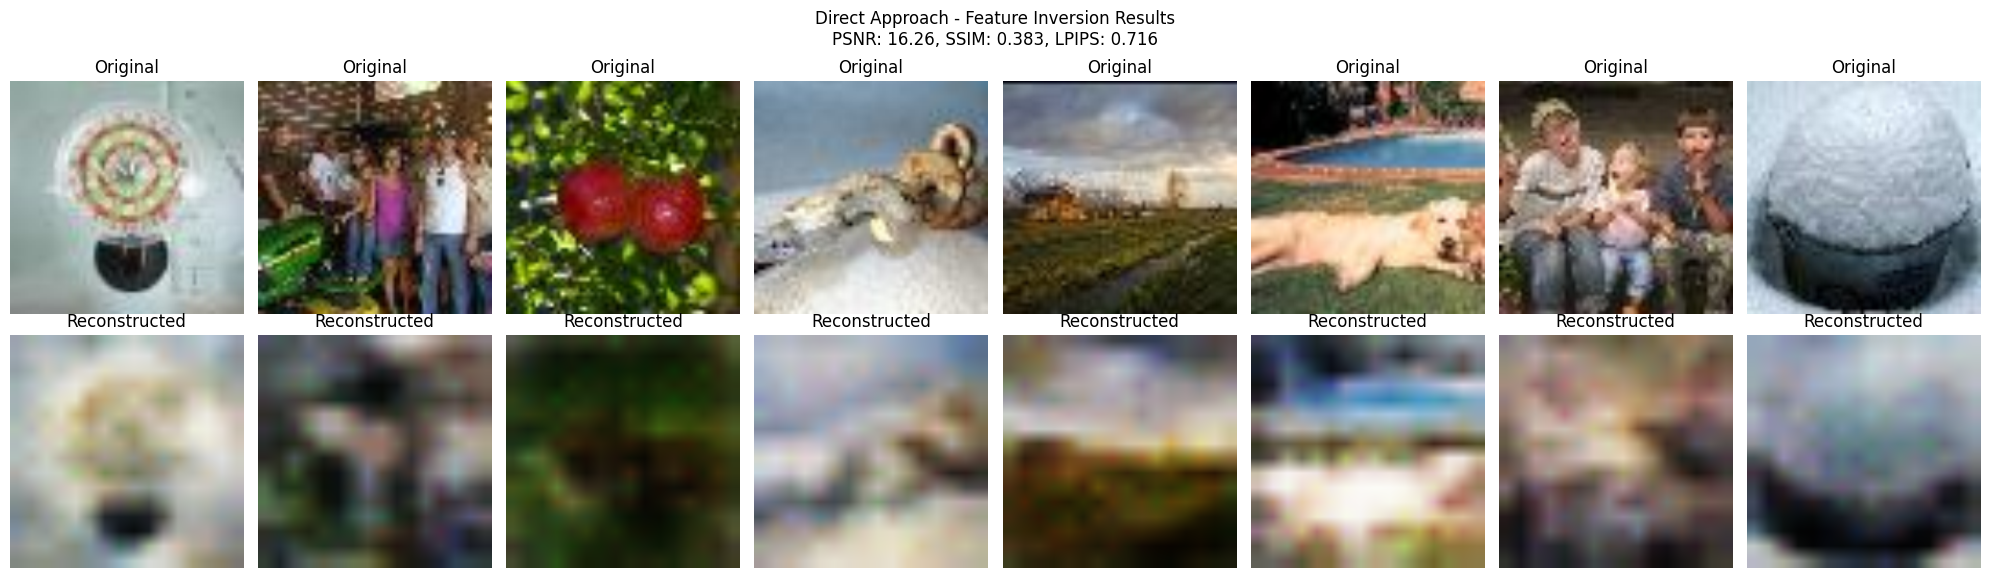


Training Decoder Optimization Approach


Epoch 0:  20%|██        | 50/250 [00:14<00:56,  3.57it/s, Loss=0.2316, Recon=0.2215, TV=0.1014]


Epoch 0: Loss = 0.0679


Epoch 1:  20%|██        | 50/250 [00:14<00:56,  3.57it/s, Loss=0.2023, Recon=0.1972, TV=0.0512]


Epoch 1: Loss = 0.0451


Epoch 2:  20%|██        | 50/250 [00:14<00:56,  3.57it/s, Loss=0.2188, Recon=0.2156, TV=0.0319]


Epoch 2: Loss = 0.0480


Epoch 3:  20%|██        | 50/250 [00:14<00:56,  3.57it/s, Loss=0.3163, Recon=0.3121, TV=0.0420]


Epoch 3: Loss = 0.0472


Epoch 4:  20%|██        | 50/250 [00:13<00:55,  3.58it/s, Loss=0.2308, Recon=0.2285, TV=0.0228]


Epoch 4: Loss = 0.0497


Epoch 5:  20%|██        | 50/250 [00:13<00:55,  3.58it/s, Loss=0.1996, Recon=0.1977, TV=0.0197]


Epoch 5: Loss = 0.0490


Epoch 6:  20%|██        | 50/250 [00:14<00:56,  3.57it/s, Loss=0.3293, Recon=0.3264, TV=0.0293]


Epoch 6: Loss = 0.0476


Epoch 7:  20%|██        | 50/250 [00:13<00:55,  3.57it/s, Loss=0.2506, Recon=0.2490, TV=0.0159]


Epoch 7: Loss = 0.0451


Epoch 8:  20%|██        | 50/250 [00:14<00:56,  3.57it/s, Loss=0.2454, Recon=0.2436, TV=0.0184]


Epoch 8: Loss = 0.0453


Epoch 9:  20%|██        | 50/250 [00:14<00:56,  3.57it/s, Loss=0.1662, Recon=0.1643, TV=0.0194]


Epoch 9: Loss = 0.0479


Epoch 10:  20%|██        | 50/250 [00:14<00:56,  3.56it/s, Loss=0.2082, Recon=0.2067, TV=0.0149]


Epoch 10: Loss = 0.0488


Epoch 11:   5%|▌         | 13/250 [00:03<01:06,  3.58it/s, Loss=0.1830, Recon=0.1814, TV=0.0162]

In [ ]:
main()